In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, Sampler
from copy import deepcopy
from tqdm import tqdm
import sys
sys.path.append('../FakeDatasetMaking/')
from pair_nomet_creation_aug21 import KinematicDataset, EpochSampler
from scipy import stats



In [2]:
# hidden_layers=[16,26,32,32,32,48,52,48,32,32,32,26]
hidden_layers = [64 for i in range(20)]

modelsavedpath='/home/ddemler/HNLclassifier/saved_files/saved_models/FNN_FeatureRegression/aug21_alldata_inp5.pt'


In [3]:
# class CustomKinematicNet(nn.Module):
#     def __init__(self, input_size, hidden_layers, lenoutput, activation_fn=F.relu):
#         """
#         Args:
#         - input_size (int): Size of the input layer.
#         - hidden_layers (list of int): Sizes of each hidden layer.
#         - lenoutput (int): Size of the output layer.
#         - activation_fn (callable): Activation function to use.
#         """
#         super(CustomKinematicNet, self).__init__()
        
#         # Create the list of layers
#         layers = [nn.Linear(input_size, hidden_layers[0])]
#         for i in range(len(hidden_layers) - 1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
#         layers.append(nn.Linear(hidden_layers[-1], lenoutput))
        
#         self.layers = nn.ModuleList(layers)
#         self.activation_fn = activation_fn
        
#     def forward(self, x):
#         for layer in self.layers[:-1]:
#             x = self.activation_fn(layer(x))
#         return self.layers[-1](x)

# class CustomKinematicNet(nn.Module):
#     def __init__(self, input_size, hidden_layers, lenoutput, activation_fn=F.relu):
#         """
#         Args:
#         - input_size (int): Size of the input layer.
#         - hidden_layers (list of int): Sizes of each hidden layer.
#         - lenoutput (int): Size of the output layer.
#         - activation_fn (callable): Activation function to use.
#         """
#         super(CustomKinematicNet, self).__init__()
        
#         # Create the list of layers
#         layers = [nn.Linear(input_size, hidden_layers[0])]
#         for i in range(len(hidden_layers) - 1):
#             # Adjusting the input sizes for concatenation
#             layers.append(nn.Linear(hidden_layers[i] + input_size, hidden_layers[i + 1]))
#             # layers.append(nn.Linear(hidden_layers[i] + input_size, hidden_layers[i + 1]))
#         layers.append(nn.Linear(hidden_layers[-1] + input_size, lenoutput))
        
        
#         self.layers = nn.ModuleList(layers)
#         self.activation_fn = activation_fn
        
#     def forward(self, x):
#         inputs = x
#         # First layer is handled separately
#         x = self.activation_fn(self.layers[0](x))
        
#         # From the second layer onwards
#         for layer in self.layers[1:-1]:
#             x = self.activation_fn(layer(torch.cat((x, inputs), dim=-1)))
        
#         # Last layer
#         return self.layers[-1](torch.cat((x, inputs), dim=-1))

class CustomKinematicNet(nn.Module):
    def __init__(self, input_size, hidden_layers, lenoutput, activation_fn=F.relu):
        super(CustomKinematicNet, self).__init__()
        
        layers = []
        for i in range(len(hidden_layers)):
            # Check if this is a layer where we reintroduce the inputs
            if (i % 5 == 0) and (i != 0):
                in_features = hidden_layers[i-1] + input_size
            else:
                in_features = hidden_layers[i-1] if i > 0 else input_size
            out_features = hidden_layers[i]
            layers.append(nn.Linear(in_features, out_features))
        
        # Adjusting the input size for the final layer
        if len(hidden_layers) % 5 == 0:
            layers.append(nn.Linear(hidden_layers[-1] + input_size, lenoutput))
        else:
            layers.append(nn.Linear(hidden_layers[-1], lenoutput))
        
        self.layers = nn.ModuleList(layers)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        inputs = x
        for idx, layer in enumerate(self.layers[:-1]):
            if (idx % 5 == 0) and (idx != 0):
                x = self.activation_fn(layer(torch.cat((x, inputs), dim=-1)))
            else:
                x = self.activation_fn(layer(x))
        
        # Check if the output layer needs the original inputs
        if (len(self.layers) - 1) % 5 == 0:
            return self.layers[-1](torch.cat((x, inputs), dim=-1))
        return self.layers[-1](x)




test_dataset = KinematicDataset(num_events=500000, seed=1000000)
input_dim, output_dim = test_dataset.usefulvariables()

test_sampler = EpochSampler(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=320, sampler=test_sampler)

(500000, 13)
(500000, 13)


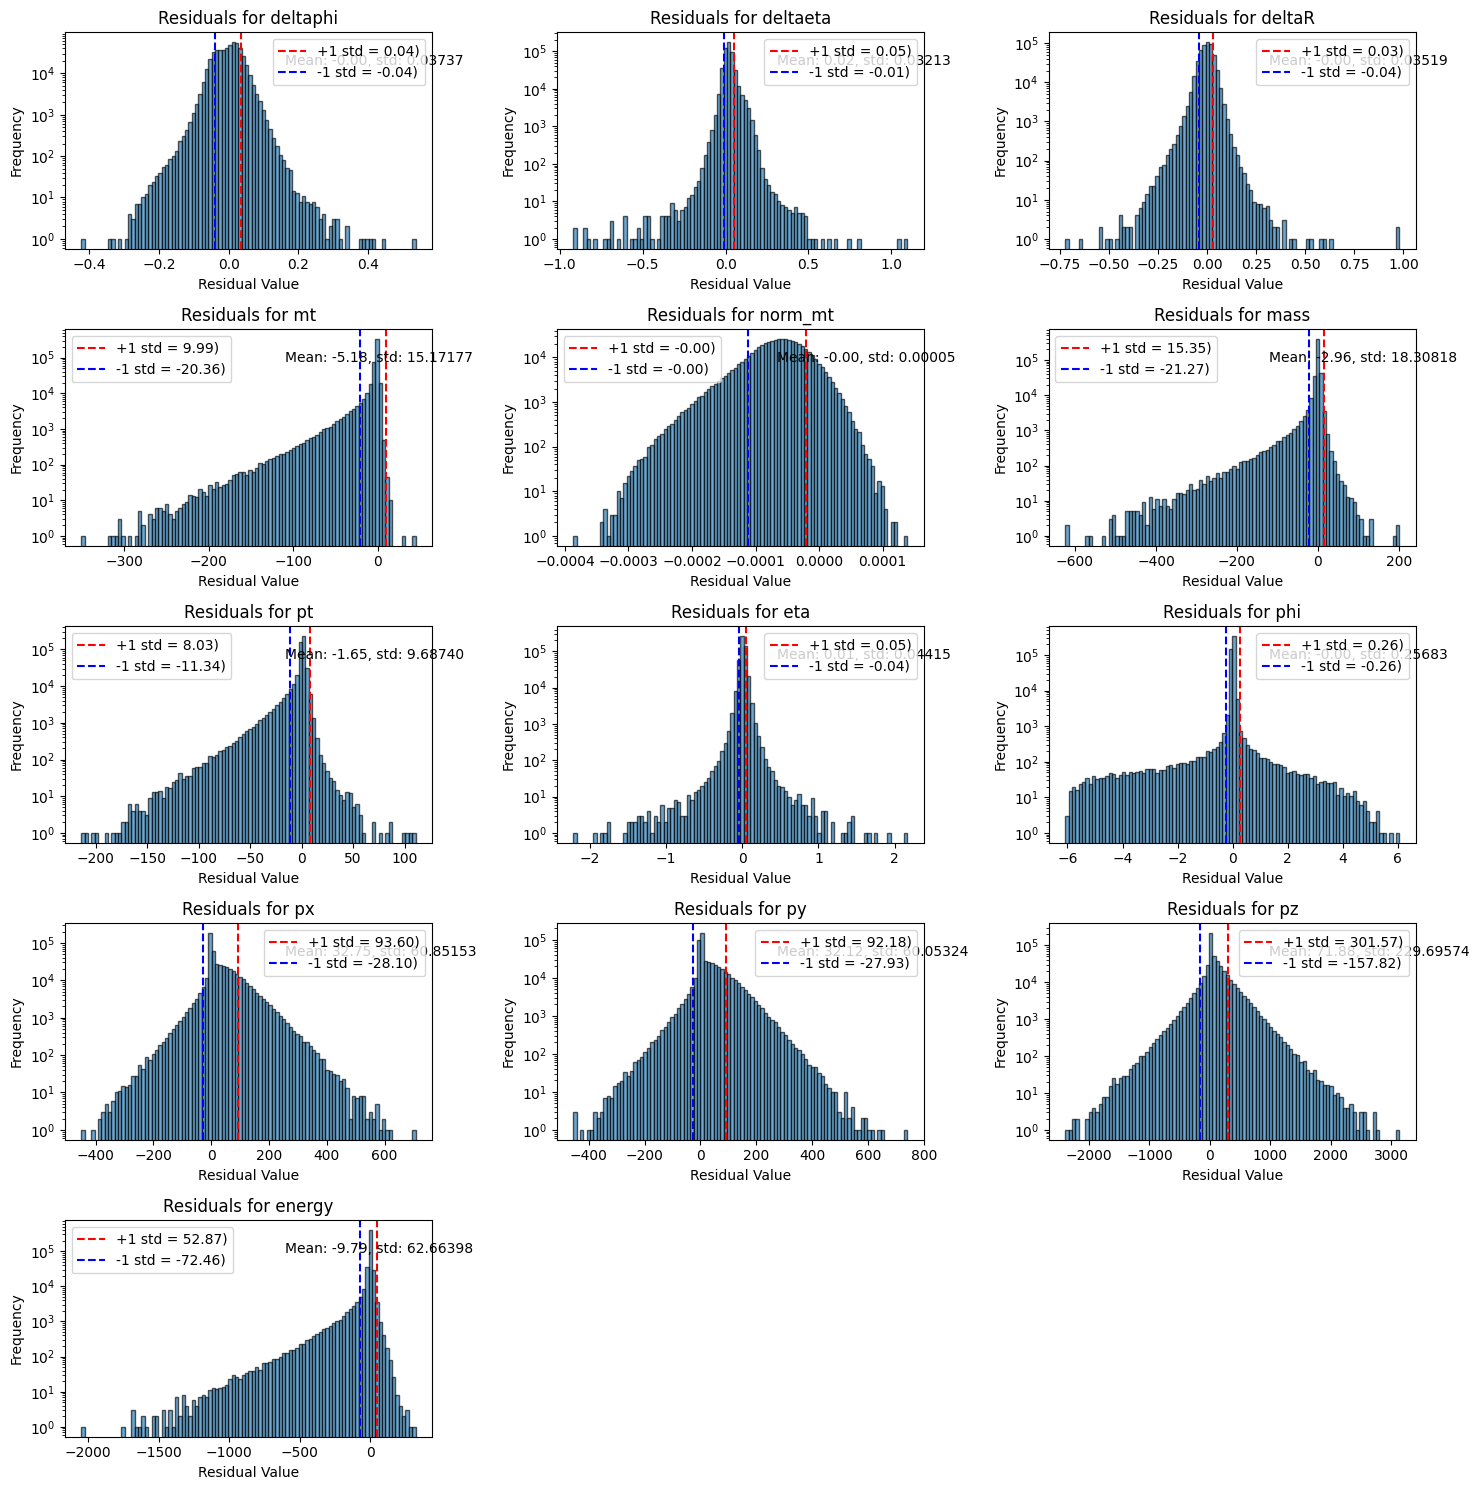

In [6]:
out_feats=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt', 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']
# out_feats=out_feats[5:8]
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# modelsavedpath='/home/ddemler/HNLclassifier/fnn_FeatureRegression/fnn_aug17all_oldloss.pt'
model=CustomKinematicNet(input_size=input_dim, hidden_layers=hidden_layers, lenoutput=output_dim, activation_fn=F.tanh)
model.load_state_dict(torch.load(modelsavedpath))
model.to(device)
# out_feats=['deltaphi', 'deltaeta', 'deltaR', 'mt', 'norm_mt', 'mass', 'pt', 'eta' , 'phi',  'px', 'py', 'pz', 'energy']


residuals=np.array([])
y_total=np.array([])
y_pred_total=np.array([])
for i, (x,y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    y_pred_total=np.append(y_pred_total, y_pred.cpu().detach().numpy())
    y_total=np.append(y_total, y.cpu().detach().numpy())


    # residuals=np.append(residuals, y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())

    # residuals.append(y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())


numfeatures=len(out_feats)
y_pred_total = y_pred_total.reshape(-1,numfeatures)
y_total = y_total.reshape(-1,numfeatures)

print(y_pred_total.shape)
print(y_total.shape)

residuals = [[] for _ in range(numfeatures)]
label_values = [[] for _ in range(numfeatures)]

for i in range(numfeatures):
    y_curr=y_total[:,i]
    # print("ycurr shape before reshape", y_curr.shape)
    
    # print("ycurr shape after reshape", y_curr.shape)
    y_pred_curr=y_pred_total[:,i]
    # y_pred_curr=y_pred_curr.reshape(-1,1)
    # print("ypredcurr shape after reshape", y_pred_curr.shape)
    residuals_curr = y_pred_curr - y_curr
    residuals[i]=residuals_curr
    label_values[i]=y_curr

residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays
# residual_medians = [np.median(res) for res in residuals]
residual_std_devs = [np.std(res) for res in residuals]
residual_means = [np.mean(res) for res in residuals]


num_rows = numfeatures // 3 + 1
num_cols = 3


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
flat_axes = axes.flatten()

for i, ax in enumerate(flat_axes[:numfeatures]):
    ax.hist(residuals[i], bins=100, edgecolor='k', alpha=0.65)
    ax.axvline(x=residual_means[i] + residual_std_devs[i], color='r', linestyle='--', label=f'+1 std = {residual_means[i] + residual_std_devs[i]:.2f})')
    ax.axvline(x=residual_means[i] - residual_std_devs[i], color='b', linestyle='--', label=f'-1 std = {residual_means[i] - residual_std_devs[i]:.2f})')
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_yscale('log')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    
    # Display the mean value on the plot
    mean_text = f"Mean: {residual_means[i]:.2f}, std: {residual_std_devs[i]:.5f}"
    ax.text(0.6, 0.85, mean_text, transform=ax.transAxes)
    

for ax in flat_axes[numfeatures:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
    
    


/tmp/ddemler/ipykernel_77173/463727448.py:8: RuntimeWarning: invalid value encountered in log10
  bins = [np.logspace(np.log10(min(label_values[i])), np.log10(max(label_values[i])), num=10) for i in selected_indices]
/tmp/ddemler/ipykernel_77173/463727448.py:59: RuntimeWarning: invalid value encountered in sqrt
  bin_std_uncertainties = bin_stds / np.sqrt(2 * (bin_counts - 1))


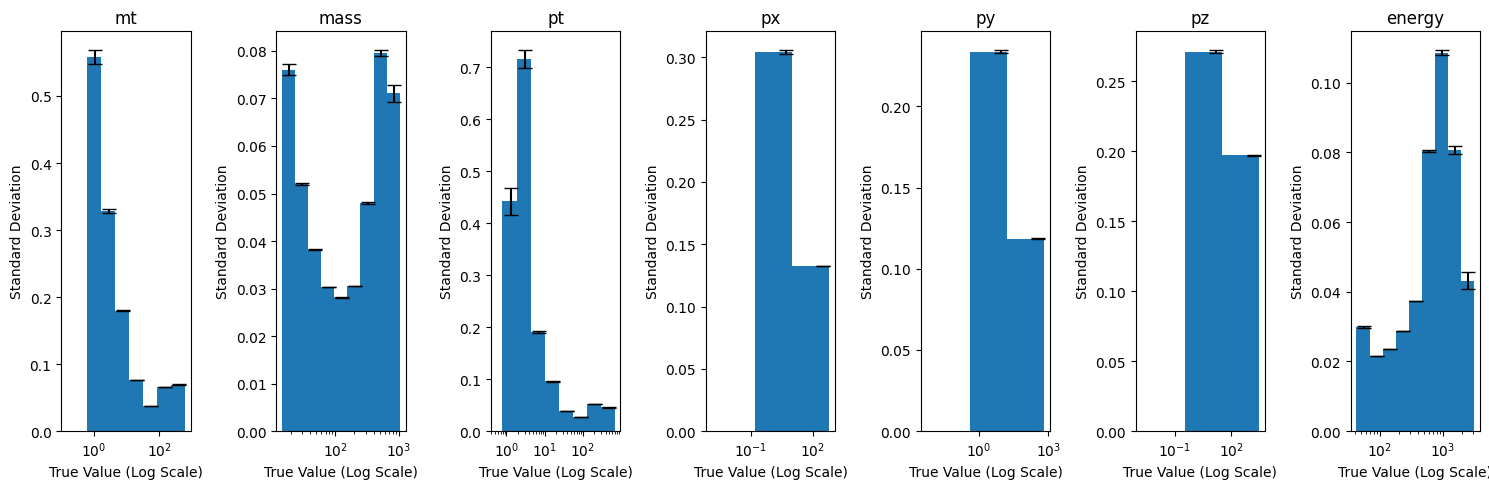

In [18]:

selected_features = ['mt', 'mass', 'pt', 'px', 'py', 'pz', 'energy']
selected_indices = [out_feats.index(feat) for feat in selected_features]

# Calculate relative residuals
relative_residuals = [residuals[i] / label_values[i] for i in selected_indices]

# Define logarithmic bins for each feature
bins = [np.logspace(np.log10(min(label_values[i])), np.log10(max(label_values[i])), num=10) for i in selected_indices]

problematic_features = ['px', 'py', 'pz']

for feature in problematic_features:
    index = selected_features.index(feature)
    feature_label_values = np.abs(label_values[selected_indices[index]])  # Take absolute value
    bins[index] = np.logspace(np.log10(min(feature_label_values)),
                              np.log10(max(feature_label_values)),
                              num=5)

# Now, print the new bins for these problematic features
problematic_bins = {feature: bins[selected_features.index(feature)] for feature in problematic_features}
problematic_bins



# Adjusting label_values and relative_residuals based on the requirements

filtered_label_values = []
filtered_relative_residuals = []

for idx, feature in enumerate(selected_features):
    feature_index = selected_indices[idx]
    
    # Mask for px, py, pz
    if feature in ['px', 'py', 'pz']:
        mask = (label_values[feature_index] > 1) | (label_values[feature_index] < -1)
    # Mask for other features
    else:
        mask = label_values[feature_index] > 1

    filtered_label_values.append(label_values[feature_index][mask])
    filtered_relative_residuals.append(relative_residuals[idx][mask])

fig, axes = plt.subplots(nrows=1, ncols=len(selected_features), figsize=(15, 5))

for idx, ax in enumerate(axes):
    
    bin_stds, bin_edges, binnumber = stats.binned_statistic(filtered_label_values[idx],
                                                            filtered_relative_residuals[idx],
                                                            statistic='std',
                                                            bins=bins[idx])

    bin_counts, _, _ = stats.binned_statistic(filtered_label_values[idx],
                                              filtered_relative_residuals[idx],
                                              statistic='count',
                                              bins=bins[idx])
    bin_std_uncertainties = bin_stds / np.sqrt(2 * (bin_counts - 1))

    bar_widths = np.diff(bin_edges)

    ax.bar(x=bin_edges[:-1], height=bin_stds, width=bar_widths, align='edge', yerr=bin_std_uncertainties, capsize=5)
    
    ax.set_xscale('log')
    ax.set_title(f'{selected_features[idx]}')
    ax.set_xlabel('True Value (Log Scale)')
    ax.set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()
